In [0]:
from google.colab import drive
drive.mount('/content/drive')

#Step 0: Change Colab runtime type to GPU
#Step 1: Download the source code, it will create LightGBM directory on your Colab instance:
!git clone --recursive https://github.com/Microsoft/LightGBM
#Step 2: Move the context to LightGBM directory
%cd /content/LightGBM
#Step 3: Create build directory under LightGBM (Installation notes also mentioned about going inside the build directory but that will not help in next step, so skipping it)
!mkdir build
#Step 4: Install cmake with GPU option and nproc:
!cmake -DUSE_GPU=1 #avoid ..
!make -j$(nproc)
#Step 5: Get python-pip
!sudo apt-get -y install python-pip
#Step 6: Install required packages (Here include all packages that you need e.g. if you dont mention pandas then it can give errors later):
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
#Step 7: Move context to python-package:
%cd /content/LightGBM/python-package
#Step 8: Compile
!sudo python setup.py install --precompile

import lightgbm

!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

import pandas as pd
import numpy as np
!pip install ujson
import ujson as json
import seaborn as sns; sns.set()
from matplotlib import pylab as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import ShuffleSplit, KFold
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
!pip install eli5 
import eli5

from sklearn.model_selection import train_test_split
from eli5.permutation_importance import get_score_importances
from sklearn.metrics import roc_auc_score

from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm_notebook
import os
import collections
import re
from scipy.spatial import distance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Cloning into 'LightGBM'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 14888 (delta 9), reused 11 (delta 4), pack-reused 14855
Receiving objects: 100% (14888/14888), 10.32 MiB | 7.02 MiB/s, done.
Resolving deltas: 100% (10720/10720), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'compute'
Cloning into '/con

Using TensorFlow backend.


# Description of the player-features

There are 245 different features in the dataset. It might be daunting at first, however there are 10 different players (2 teams with 5 players in each), and there are only 24 unique player-features for each player (which gives us 240 player-features in total). The remaining 5 features are general game-features which I don't use here.

The description of each player-feature is given in the following table (source: dota2.gamepedia.com). This might be helpfull for people who have never played Dota 2 like me.


|  Feature  | Description |
| ------------- |:-------------| 
| **hero_id** | ID of player's hero (int64). [Heroes](https://dota2.gamepedia.com/Heroes) are the essential element of Dota 2, as the course of the match is dependent on their intervention. During a match, two opposing teams select five out of 117 heroes that accumulate experience and gold to grow stronger and gain new abilities in order to destroy the opponent's Ancient. Most heroes have a distinct role that defines how they affect the battlefield, though many heroes can perform multiple roles. A hero's appearance can be modified with equipment.|
| **kills** | Number of killed players (int64).|
| **deaths** | Number of deaths of the player (int64).|
| **gold** | Amount of gold (int64). [Gold](https://dota2.gamepedia.com/Gold) is the currency used to buy items or instantly revive your hero. Gold can be earned from killing heroes, creeps, or buildings. |
| **xp** | Experience points (int64). [Experience](https://dota2.gamepedia.com/Experience) is an element heroes can gather by killing enemy units, or being present as enemy units get killed. On its own, experience does nothing, but when accumulated, it increases the hero's level, so that they grow more powerful.   |
| **lh** | Number of last hits (int64). [Last-hitting](https://dota2.gamepedia.com/Creep_control_techniques#Last-hitting) is a technique where you (or a creep under your control) get the 'last hit' on a neutral creep, enemy lane creep, or enemy hero. The hero that dealt the killing blow to the enemy unit will be awarded a bounty.|
| **denies** | Number of denies (int64). [Denying](https://dota2.gamepedia.com/Denying) is the act of preventing enemy heroes from getting the last hit on a friendly unit by last hitting the unit oneself. Enemies earn reduced experience if the denied unit is not controlled by a player, and no experience if it is a player controlled unit. Enemies gain no gold from any denied unit. |
| **assists** | Number of [assists](https://dota2.gamepedia.com/Gold#Assists_.28AoE_gold.29) (int64). Allied heroes within 1300 radius of a killed enemy, including the killer, receive experience and reliable gold if they assisted in the kill. To qualify for an assist, the allied hero merely has to be within the given radius of the dying enemy hero. |
| **health** | Health points (int64). [Health](https://dota2.gamepedia.com/Health) represents the life force of a unit. When a unit's current health reaches 0, it dies. Every hero has a base health pool of 200. This value exists for all heroes and cannot be altered. This means that a hero's maximum health cannot drop below 200. |
| **max_health** | Hero's maximum health pool (int64).|
| **max_mana** | Hero's maximum mana pool (float64). [Mana](https://dota2.gamepedia.com/Mana) represents the magic power of a unit. It is used as a cost for the majority of active and even some passive abilities. Every hero has a base mana pool of 75, while most non-hero units only have a set mana pool if they have abilities which require mana, with a few exceptions. These values cannot be altered. This means that a hero's maximum mana cannot drop below 75. |
| **level** | [Level](https://dota2.gamepedia.com/Experience#Leveling) of player's hero (int64). Each hero begins at level 1, with one free ability point to spend. Heroes may level up by acquiring certain amounts of experience. Upon leveling up, the hero's attributes increase by fixed amounts (unique for each hero), which makes them overall more powerful. Heroes may also gain more ability points by leveling up, allowing them to learn new spells, or to improve an already learned spell, making it more powerful. Heroes can gain a total for 24 levels, resulting in level 25 as the highest possible level a hero can reach. |
| **x** | Player's X coordinate (int64) |
| **y** | Player's Y coordinate (int64) |
| **stuns** | Total stun duration of all stuns (float64). [Stun](https://dota2.gamepedia.com/Stun) is a status effect that completely locks down affected units, disabling almost all of its capabilities. |
| **creeps_stacked** | Number of stacked creeps (int64). [Creep Stacking](https://dota2.gamepedia.com/Creep_Stacking) is the process of drawing neutral creeps away from their camps in order to increase the number of units in an area. By pulling neutral creeps beyond their camp boundaries, the game will generate a new set of creeps for the player to interact with in addition to any remaining creeps. This is incredibly time efficient, since it effectively increases the amount of gold available for a team. |
| **camps_stacked** | Number of stacked camps  (int64). |
| **rune_pickups** | Number of picked up [runes](https://dota2.gamepedia.com/Runes)  (int64).  |
| **firstblood_claimed** | boolean feature? (int64) |
| **teamfight_participation** |  Team fight participation rate? (float64) |
| **towers_killed** | Number of killed/destroyed Towers (int64). [Towers](https://dota2.gamepedia.com/Buildings#Towers) are the main line of defense for both teams, attacking any non-neutral enemy that gets within their range. Both factions have all three lanes guarded by three towers each. Additionally, each faction's Ancient have two towers as well, resulting in a total of 11 towers per faction. Towers come in 4 different tiers. |
| **roshans_killed** | Number of killed Roshans  (int64). [Roshan](https://dota2.gamepedia.com/Roshan) is the most powerful neutral creep in Dota 2. It is the first unit which spawns, right as the match is loaded. During the early to mid game, he easily outmatches almost every hero in one-on-one combat. Very few heroes can take him on alone during the mid-game. Even in the late game, lots of heroes struggle fighting him one on one, since Roshan grows stronger as time passes. |
| **obs_placed** | Number of observer-wards placed by a player (int64). [Observer Ward](https://dota2.gamepedia.com/Observer_Ward), an invisible watcher that gives ground vision in a 1600 radius to your team. Lasts 6 minutes. |
| **sen_placed** | Number of sentry-wards placed by a player (int64) [Sentry Ward](https://dota2.gamepedia.com/Sentry_Ward), an invisible watcher that grants True Sight, the ability to see invisible enemy units and wards, to any existing allied vision within a radius. Lasts 6 minutes.|

**Note**: I am not sure about the meaning of some features: `stuns`, `firstblood_claimed` and `teamfight_participation`. Also, the number of towers killed by a team in a few cases is 12, whereas according to wiki the number of towers of each team is 11.
Please correct me if I am wrong in the comments and help to clarrify the meaning of these features.

### загрузка

In [0]:
path_data = '/content/drive/My Drive/Courses/mlcourse/4/data_dota2/'

df_train_features = pd.read_csv(path_data + 'train_features.csv', index_col='match_id_hash')
df_train_targets = pd.read_csv(path_data + 'train_targets.csv', index_col='match_id_hash')

df_test_features = pd.read_csv(path_data + 'test_features.csv', index_col='match_id_hash')

df_train_all = pd.merge(df_train_features, df_train_targets, how='inner', left_index=True, right_index=True)
df_train_all['radiant_win'] = df_train_all['radiant_win'].astype(int)

df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_x,r1_y,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r2_hero_id,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,...,d4_health,d4_max_health,d4_max_mana,d4_level,d4_x,d4_y,d4_stuns,d4_creeps_stacked,d4_camps_stacked,d4_rune_pickups,d4_firstblood_claimed,d4_teamfight_participation,d4_towers_killed,d4_roshans_killed,d4_obs_placed,d4_sen_placed,d5_hero_id,d5_kills,d5_deaths,d5_assists,d5_denies,d5_gold,d5_lh,d5_xp,d5_health,d5_max_health,d5_max_mana,d5_level,d5_x,d5_y,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,543,7,533,358,600,350.93784,2,116,122,0.000000,0,0,1,0,0.000000,0,0,0,0,78,0,0,0,3,399,4,478,636,720,254.93774,...,760,760,326.93780,2,90,150,0.000000,0,0,2,1,1.0,0,0,1,0,34,0,0,0,0,851,11,870,593,680,566.93805,3,128,128,0.000000,0,0,0,0,0.00,0,0,0,0
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,5257,52,3937,1160,1160,566.93805,8,76,78,0.000000,0,0,0,0,0.437500,0,0,0,0,96,3,1,2,3,3394,19,3897,1352,1380,386.93787,...,567,1160,410.93790,6,124,142,0.000000,0,0,6,0,0.5,0,0,0,0,92,0,2,0,1,1423,8,1136,800,800,446.93793,4,180,176,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,176,0,0,680,680,506.93800,1,118,118,0.000000,0,0,0,0,0.000000,0,0,0,0,51,0,0,0,0,176,0,0,720,720,278.93777,...,600,600,302.93777,1,176,110,0.000000,0,0,0,0,0.0,0,0,0,0,17,0,0,0,0,96,0,0,640,640,446.93793,1,162,162,0.000000,0,0,0,0,0.00,0,0,0,0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,1613,0,1471,900,900,290.93777,4,170,96,2.366089,0,0,5,0,0.571429,0,0,0,0,99,1,0,1,2,2816,30,3602,878,1100,494.93796,...,1160,1160,386.93787,4,176,100,4.998863,0,0,2,0,0.0,0,0,0,0,86,0,1,0,1,1333,2,1878,630,740,518.93800,5,82,160,8.664527,3,1,3,0,0.00,0,0,2,0
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,1404,9,1351,1000,1000,338.93784,4,80,164,9.930903,0,0,4,0,0.500000,0,0,0,0,69,1,0,0,0,1840,14,1693,868,1000,350.93784,...,680,680,374.93787,4,176,108,13.596678,0,0,2,0,0.5,0,0,0,0,1,0,1,1,8,2199,32,1919,692,740,302.93777,5,104,162,0.000000,2,1,2,0,0.25,0,0,0,0


In [0]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,False,992,837,NaN
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
46a0ddce8f7ed2a8d9bd5edcbb925682,576,True,1952,1376,NaN
b1b35ff97723d9b7ade1c9c3cf48f770,453,False,2001,1548,NaN


### первичное исследование

In [0]:
# Check if there is missing data
print(df_train_features.isnull().values.any())
print(df_test_features.isnull().values.any())

False
False


In [0]:
print(f'Number of samples in train: {df_train_features.shape[0]}')
print(f'Number of columns in train: {df_train_features.shape[1]}')

Number of samples in train: 39675
Number of columns in train: 245


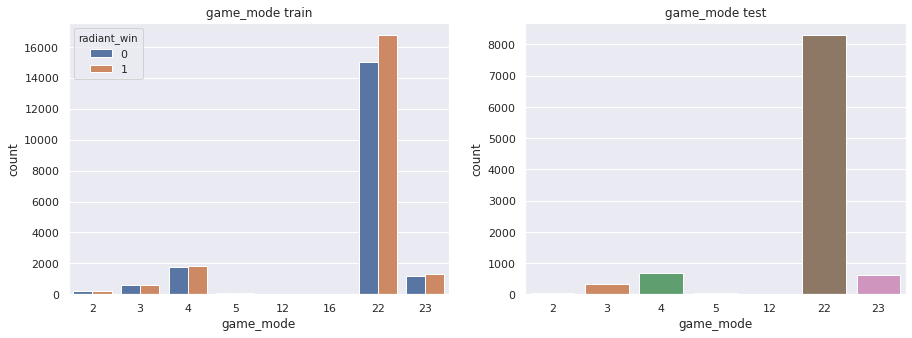

In [0]:
    plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.countplot(x='game_mode', hue='radiant_win', data=df_train_all)
plt.title('game_mode train')
plt.subplot(122)
sns.countplot(x='game_mode', data=df_test_features)
plt.title('game_mode test');

In [0]:
df_train_all.groupby(by='game_mode')['duration'].describe()

,count,mean,std,min,25%,50%,75%,max
game_mode,,,,,,,,
2,408.0,2388.514706,623.417848,973.0,1955.00,2283.0,2780.00,4286.0
3,1200.0,2485.902500,629.775421,1064.0,2047.75,2408.0,2820.25,5305.0
4,3564.0,2273.587823,627.032994,901.0,1840.75,2234.0,2665.00,5288.0
5,188.0,2441.537234,611.368443,941.0,2026.50,2400.5,2838.75,4472.0
12,5.0,2982.800000,644.395220,2535.0,2536.00,2577.0,3279.00,3987.0
16,2.0,3560.500000,1044.396716,2822.0,3191.25,3560.5,3929.75,4299.0
22,31762.0,2397.058403,647.225928,902.0,1938.00,2329.0,2789.00,5638.0
23,2546.0,1454.335035,370.482565,901.0,1172.25,1396.0,1653.75,3712.0


In [0]:
df_train_all['game_time_x'].describe()

count    39675.000000
mean      1146.082798
std        767.206621
min          0.000000
25%        521.000000
50%       1044.000000
75%       1656.000000
max       4933.000000
Name: game_time_x, dtype: float64

### кодирование hero_id

In [0]:
df_d = hero_dammies(df_new_features, 'd')
df_r = hero_dammies(df_new_features, 'r')

X = df_d.join(df_r).join(df_new_targets['radiant_win'])
y = X['radiant_win']
X = X.drop('radiant_win', axis=1).values

clf = LogisticRegression(solver='liblinear', random_state=17)

clf.fit(X, y)

y_pred = clf.predict_proba(X)[:, 1]
roc_auc_score(y, y_pred)

0.6201803470919169

### добавление центра масс расположения игроков команды

In [0]:
# где находятся герои r, когда проиграли / выиграли
# где находятся герои d, когда проиграли / выиграли

In [0]:
coord_r_columns = list(filter(lambda x: re.match('r[1-5]_[x|y]$', x), df_train_features))
columns = pd.MultiIndex.from_product([range(1, 6), ['r_x', 'r_y']], names=['hero_num', 'coord'])
coord_r = pd.DataFrame(df_train_features[coord_r_columns].values, 
                       columns=columns, 
                       index=df_train_features.index).stack('hero_num').reset_index()

coord_d_columns = list(filter(lambda x: re.match('d[1-5]_[x|y]$', x), df_train_features))
columns = pd.MultiIndex.from_product([range(1, 6), ['d_x', 'd_y']], names=['hero_num', 'coord'])
coord_d = pd.DataFrame(df_train_features[coord_d_columns].values, 
                       columns=columns, 
                       index=df_train_features.index).stack('hero_num').reset_index()

coord = pd.merge(coord_r, coord_d, how='inner', on=['match_id_hash', 'hero_num']).set_index('match_id_hash')
coord.head(10)

coord,hero_num,r_x,r_y,d_x,d_y
match_id_hash,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,1,116,122,82,170
a400b8f29dece5f4d266f49f1ae2e98a,2,124,126,174,90
a400b8f29dece5f4d266f49f1ae2e98a,3,70,156,180,84
a400b8f29dece5f4d266f49f1ae2e98a,4,170,86,90,150
a400b8f29dece5f4d266f49f1ae2e98a,5,120,100,128,128
b9c57c450ce74a2af79c9ce96fac144d,1,76,78,88,170
b9c57c450ce74a2af79c9ce96fac144d,2,78,166,156,98
b9c57c450ce74a2af79c9ce96fac144d,3,156,146,124,144
b9c57c450ce74a2af79c9ce96fac144d,4,154,148,124,142


In [0]:
coord_r_rwin = coord[df_train_targets['radiant_win']].groupby(by=['r_x', 'r_y']).size().to_frame('count').reset_index()
coord_d_rwin = coord[df_train_targets['radiant_win']].groupby(by=['d_x', 'd_y']).size().to_frame('count').reset_index()

coord_r_dwin = coord[~df_train_targets['radiant_win']].groupby(by=['r_x', 'r_y']).size().to_frame('count').reset_index()
coord_d_dwin = coord[~df_train_targets['radiant_win']].groupby(by=['d_x', 'd_y']).size().to_frame('count').reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


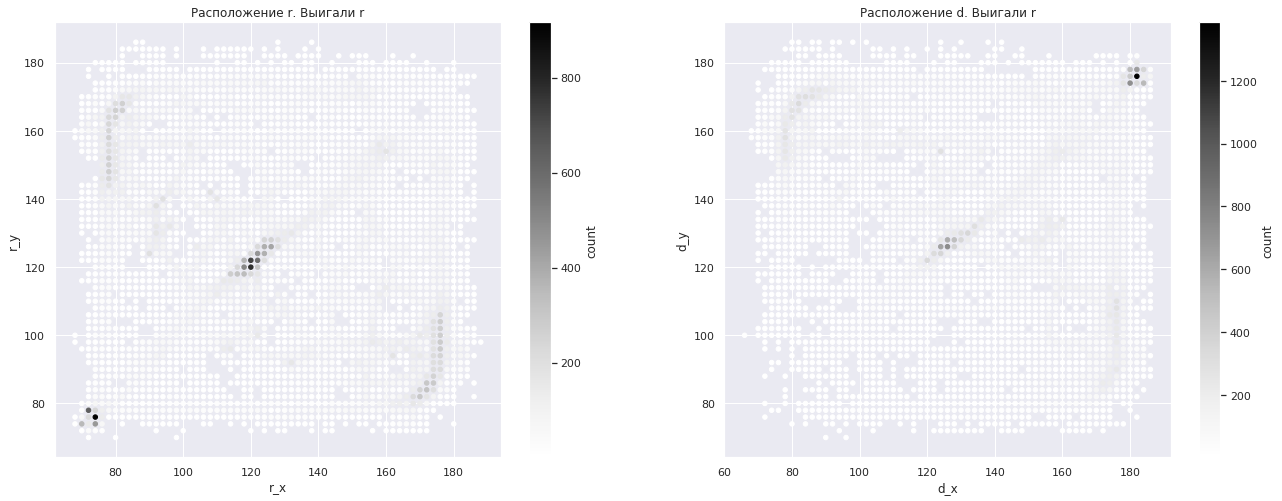

In [0]:
plt.figure(figsize=(22, 8))
coord_r_rwin.plot.scatter(x='r_x', y='r_y', c='count', ax=plt.subplot(121))
plt.title('Расположение r. Выигали r')
coord_d_rwin.plot.scatter(x='d_x', y='d_y', c='count', ax=plt.subplot(122))
plt.title('Расположение d. Выигали r')
plt.show()

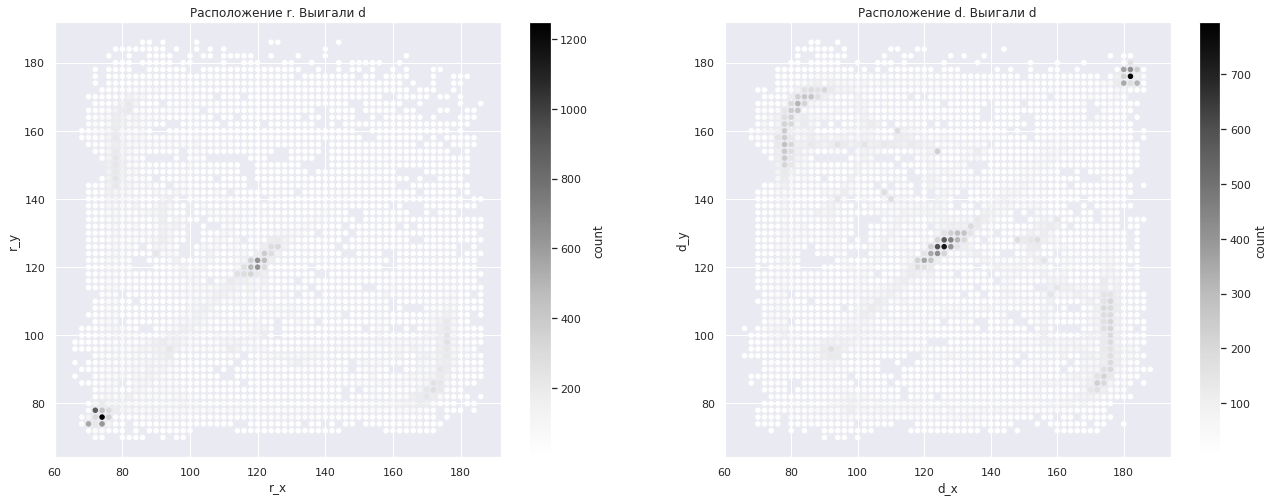

In [0]:
plt.figure(figsize=(22, 8))
coord_r_dwin.plot.scatter(x='r_x', y='r_y', c='count', ax=plt.subplot(121))
plt.title('Расположение r. Выигали d')
coord_d_dwin.plot.scatter(x='d_x', y='d_y', c='count', ax=plt.subplot(122))
plt.title('Расположение d. Выигали d')
plt.show()

In [0]:
coord_c = coord.reset_index().groupby(by='match_id_hash')[['r_x', 'r_y', 'd_x', 'd_y']].sum() / 5
coord_c.head()

coord,r_x,r_y,d_x,d_y
match_id_hash,,,,
0000c270e25494c03d5c81036463fc45,144.8,137.6,157.6,154.0
0000cbef31e13f297dbbe47d84a08169,105.2,108.0,130.8,123.6
000432b654aee6e8792ce17bb19ccf16,123.6,119.2,148.0,130.4
000a2ba6b82a4a1829ca226a880ec993,125.2,116.4,134.0,125.2
000a9891b8b7712e9a19e032b583023e,88.4,102.0,121.6,120.8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


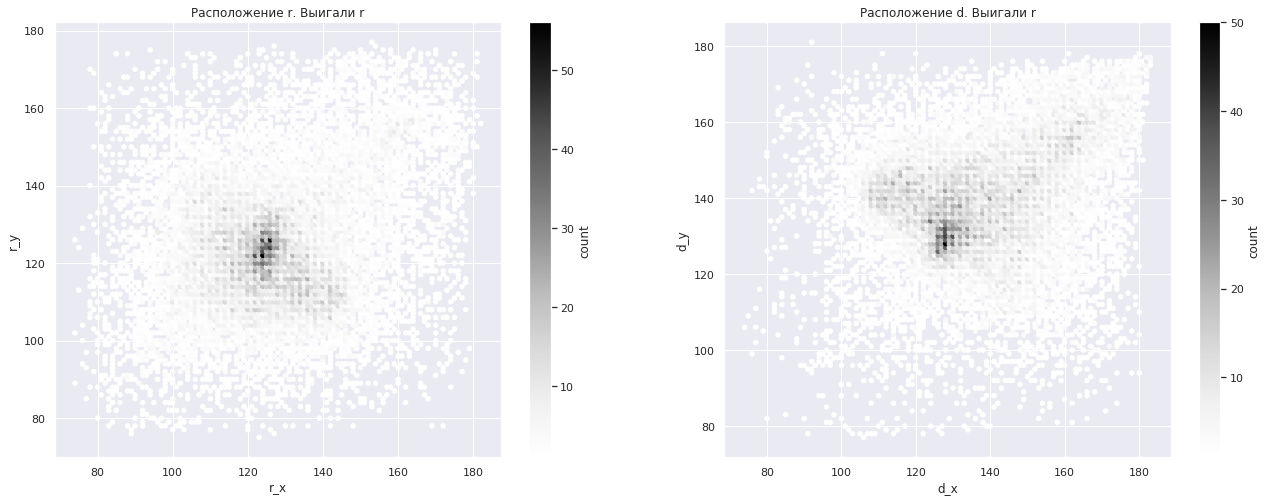

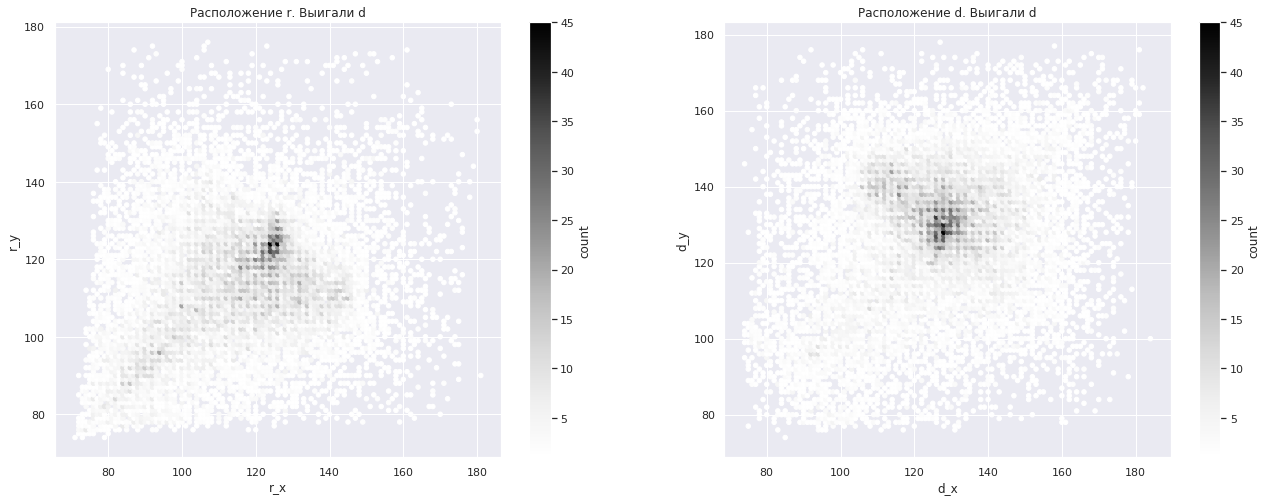

In [0]:
coord_r_rwin = coord_c[df_train_targets['radiant_win']].round().groupby(by=['r_x', 'r_y']).size().to_frame('count').reset_index()
coord_d_rwin = coord_c[df_train_targets['radiant_win']].round().groupby(by=['d_x', 'd_y']).size().to_frame('count').reset_index()

coord_r_dwin = coord_c[~df_train_targets['radiant_win']].round().groupby(by=['r_x', 'r_y']).size().to_frame('count').reset_index()
coord_d_dwin = coord_c[~df_train_targets['radiant_win']].round().groupby(by=['d_x', 'd_y']).size().to_frame('count').reset_index()

plt.figure(figsize=(22, 8))
coord_r_rwin.plot.scatter(x='r_x', y='r_y', c='count', ax=plt.subplot(121))
plt.title('Расположение r. Выигали r')
coord_d_rwin.plot.scatter(x='d_x', y='d_y', c='count', ax=plt.subplot(122))
plt.title('Расположение d. Выигали r')
plt.show()

plt.figure(figsize=(22, 8))
coord_r_dwin.plot.scatter(x='r_x', y='r_y', c='count', ax=plt.subplot(121))
plt.title('Расположение r. Выигали d')
coord_d_dwin.plot.scatter(x='d_x', y='d_y', c='count', ax=plt.subplot(122))
plt.title('Расположение d. Выигали d')
plt.show()

![alt text](https://avatars.mds.yandex.net/get-zen_doc/242954/pub_5d2c731fa2d6ed00ae61d962_5d2c7427ae56cc00ade4c890/scale_600)

In [0]:
coord_base_r = ['66', '70']
coord_base_d = ['188', '186']

In [0]:
train = add_dist_base(df_new_features)
train = add_dist_foreign_base(train)

In [0]:
train.merge(df_new_targets, 
            how='inner', 
            left_index=True, 
            right_index=True)[['r_x', 'r_y', 'd_x', 'd_y', 
                               'dist_base_r', 'dist_base_d', 'dist_foreign_base_r', 'dist_foreign_base_d', 'radiant_win']].corr()

,r_x,r_y,d_x,d_y,dist_base_r,dist_base_d,dist_foreign_base_r,dist_foreign_base_d,radiant_win
r_x,1.000000,0.319139,0.580437,0.343966,0.844307,-0.570224,-0.832152,0.580117,0.308888
r_y,0.319139,1.000000,0.334585,0.648278,0.766254,-0.582716,-0.782023,0.589492,0.326872
d_x,0.580437,0.334585,1.000000,0.321472,0.570216,-0.834646,-0.570918,0.841894,0.301395
d_y,0.343966,0.648278,0.321472,1.000000,0.582408,-0.779728,-0.602041,0.772308,0.323608
dist_base_r,0.844307,0.766254,0.570216,0.582408,1.000000,-0.694154,-0.977626,0.712480,0.383916
dist_base_d,-0.570224,-0.582716,-0.834646,-0.779728,-0.694154,1.000000,0.713585,-0.978438,-0.378687
dist_foreign_base_r,-0.832152,-0.782023,-0.570918,-0.602041,-0.977626,0.713585,1.000000,-0.716749,-0.391608
dist_foreign_base_d,0.580117,0.589492,0.841894,0.772308,0.712480,-0.978438,-0.716749,1.000000,0.382778
radiant_win,0.308888,0.326872,0.301395,0.323608,0.383916,-0.378687,-0.391608,0.382778,1.000000


### модели

In [0]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=17)

def simple_tree(X, y, cv=cv):
    model = RandomForestClassifier(n_estimators=100, 
                                   max_depth=None, 
                                   min_samples_leaf=3, 
                                   n_jobs=-1, 
                                   random_state=17)
    # calcuate ROC-AUC for each split
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
    return cv_scores

In [0]:
def lgb_eval(num_leaves,max_depth,lambda_l2,lambda_l1,min_child_samples, min_data_in_leaf):
    params = {
    "device_type":"gpu",
    "objective" : "binary",
    "metric" : "auc", 
    'is_unbalance': True,
    "num_leaves" : int(num_leaves),
    "max_depth" : int(max_depth),
    "lambda_l2" : lambda_l2,
    "lambda_l1" : lambda_l1,
    "num_threads" : 20,
    "min_child_samples" : int(min_child_samples),
    'min_data_in_leaf': int(min_data_in_leaf),
    "learning_rate" : 0.03,
    "subsample_freq" : 5,
    "bagging_seed" : 42,
    "verbosity" : -1
    }
    
    lgtrain = lightgbm.Dataset(X_train, y_train,categorical_feature=categorical_features)
    cv_result = lightgbm.cv(params,
                       lgtrain,
                       10000,
                       early_stopping_rounds=300,
                       stratified=True,
                       nfold=5)
    return cv_result['auc-mean'][-1]

def lgb_train(num_leaves,max_depth,lambda_l2,lambda_l1,min_child_samples, min_data_in_leaf):
    params = {
    #"forced_splits":"forced_splits-game_mode_turbo.json",
    "device_type":"gpu",
    "objective" : "binary",
    "metric" : "auc", 
    'is_unbalance': True,
    "num_leaves" : int(num_leaves),
    "max_depth" : int(max_depth),
    "lambda_l2" : lambda_l2,
    "lambda_l1" : lambda_l1,
    "num_threads" : 20,
    "min_child_samples" : int(min_child_samples),
    'min_data_in_leaf': int(min_data_in_leaf),
    "learning_rate" : 0.03,
    "subsample_freq" : 5,
    "bagging_seed" : 42,
    "verbosity" : -1
    }
    t_x,v_x,t_y,v_y = train_test_split(X_train, y_train,test_size=0.2)
    lgtrain = lightgbm.Dataset(t_x, t_y,categorical_feature=categorical_features)
    lgvalid = lightgbm.Dataset(v_x, v_y,categorical_feature=categorical_features)
    model = lightgbm.train(params, lgtrain, 4000, valid_sets=[lgvalid], early_stopping_rounds=400, verbose_eval=200)
    pred_test_y = model.predict(X_test, num_iteration=model.best_iteration)
    return pred_test_y, model
    
def param_tuning(init_points,num_iter,**args):
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (15, 200),
                                                'max_depth': (5, 63),
                                                'lambda_l2': (0.0, 5),
                                                'lambda_l1': (0.0, 5),
                                                'min_child_samples': (50, 5000),
                                                'min_data_in_leaf': (50, 300)
                                                })

    lgbBO.maximize(init_points=init_points, n_iter=num_iter,**args)
    return lgbBO

### важность признаков

In [0]:
def score(predict_proba):
  def func(X, y):
    y_pred = predict_proba(X)[:, 1]
    return roc_auc_score(y, y_pred)
  return func

def calc_score_decreases(X_train, y_train, X_test, y_test, model):
  model.fit(X_train, y_train)
  
  predict_proba = model.predict_proba
  base_score, score_decreases = get_score_importances(score(predict_proba), X=X_test, y=y_test, random_state=17)
  importance = np.mean(score_decreases, axis=0)
  return base_score, importance

def calc_importance(X, y, features, model):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=17)
  
  base_score1, importance1 = calc_score_decreases(X_train, y_train, X_test, y_test, model)
  base_score2, importance2 = calc_score_decreases(X_test, y_test, X_train, y_train, model)
  base_score3, importance3 = calc_score_decreases(X, y, X, y, model)
  
  base_score = [base_score1, base_score2, base_score3]

  feature_importance = pd.DataFrame(np.array([features, importance1, importance2, importance3]).T, 
                                    columns=['Feature', 'Importance1', 'Importance2', 'Importance_all']).sort_values(by='Importance_all', ascending=False)
  return base_score, feature_importance

### признаки из json

In [0]:
def read_matches(matches_file):
    
    MATCHES_COUNT = {
        'test_matches.jsonl': 10000,
        'train_matches.jsonl': 39675,
    }
    _, filename = os.path.split(matches_file)
    total_matches = MATCHES_COUNT.get(filename)
    
    with open(matches_file) as fin:
        for line in tqdm_notebook(fin, total=total_matches):
            yield json.loads(line)

MATCH_FEATURES = [
    ('game_time', lambda m: m['game_time']),
    ('game_mode', lambda m: m['game_mode']),
    ('lobby_type', lambda m: m['lobby_type']),
    ('objectives_len', lambda m: len(m['objectives'])),
    ('chat_len', lambda m: len(m['chat'])),
]

PLAYER_FIELDS = [column[3:] for column in filter(lambda x: x.startswith('d1_'), df_train_features)]

def extract_features_csv(match):
    row = [
        ('match_id_hash', match['match_id_hash']),
    ]
    
    for field, f in MATCH_FEATURES:
        row.append((field, f(match)))
        
    for slot, player in enumerate(match['players']):
        if slot < 5:
            player_name = 'r%d' % (slot + 1)
        else:
            player_name = 'd%d' % (slot - 4)

        for field in PLAYER_FIELDS:
            column_name = '%s_%s' % (player_name, field)
            row.append((column_name, player[field]))
        row.append((f'{player_name}_ability_level', len(player['ability_upgrades'])))
        row.append((f'{player_name}_max_hero_hit', player['max_hero_hit']['value']))
        row.append((f'{player_name}_purchase_count', len(player['purchase_log'])))
        row.append((f'{player_name}_count_ability_use', sum(player['ability_uses'].values())))
        row.append((f'{player_name}_damage_dealt', sum(player['damage'].values())))
        row.append((f'{player_name}_damage_received', sum(player['damage_taken'].values())))
        row.append((f'{player_name}_count_item_use', sum(player['item_uses'].values())))

        damage_dealt_hero = 0
        damage_dealt_roshan = 0
        damage_dealt_tower = 0
        for name, value in player['damage'].items():
            if name.find('hero') != -1:
                damage_dealt_hero += value
            elif name == 'npc_dota_roshan':
                damage_dealt_roshan += value
            elif name.find('tower') != -1:
                damage_dealt_tower += value
        row.append((f'{player_name}_damage_dealt_hero', damage_dealt_hero))
        row.append((f'{player_name}_damage_dealt_roshan', damage_dealt_roshan))
        row.append((f'{player_name}_damage_dealt_tower', damage_dealt_tower))

        damage_received_hero = 0
        damage_received_roshan = 0
        for name, value in player['damage_taken'].items():
            if name.find('hero') != -1:
                damage_received_hero += value
            elif name == 'npc_dota_roshan':
                damage_received_roshan += value
        row.append((f'{player_name}_damage_received_hero', damage_received_hero))
        row.append((f'{player_name}_damage_received_roshan', damage_received_roshan))
            
    return collections.OrderedDict(row)
    
def extract_targets_csv(match, targets):
    return collections.OrderedDict([('match_id_hash', match['match_id_hash'])] + [
        (field, targets[field])
        for field in ['game_time', 'radiant_win', 'duration', 'time_remaining', 'next_roshan_team']
    ])

def get_new_features(matches_file):
    df_new_features = []

    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']
        features = extract_features_csv(match)
        df_new_features.append(features)

    df_new_features = pd.DataFrame.from_records(df_new_features).set_index('match_id_hash')
    return df_new_features

def get_new_targets(matches_file):
    df_new_targets = []

    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']
        targets = extract_targets_csv(match, match['targets'])
        df_new_targets.append(targets)

    df_new_targets = pd.DataFrame.from_records(df_new_targets).set_index('match_id_hash')
    return df_new_targets

### новые признаки

In [0]:
def add_tower_kills(df, matches_file):
    df = df.copy()
    features = []
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        radiant_tower_kills = 0
        dire_tower_kills = 0
        radiant_col_AEGIS = 0
        dire_col_AEGIS = 0
        radiant_col_AEGIS_STOLEN = 0
        dire_col_AEGIS_STOLEN = 0
        first_team_ROSHAN_KILL = 0
        radiant_first_ROSHAN_KILL = 0
        dire_first_ROSHAN_KILL = 0
        first_team_TOWER_KILL = 0
        radiant_first_TOWER_KILL = 0
        dire_first_TOWER_KILL = 0
        time_firstblood = 0

        for objective in match['objectives']:
            if objective['type'] == 'CHAT_MESSAGE_TOWER_KILL':
                if objective['team'] == 2:
                    radiant_tower_kills += 1
                if objective['team'] == 3:
                    dire_tower_kills += 1
                if first_team_TOWER_KILL == 0:
                    first_team_TOWER_KILL = objective['team']

            elif objective['type'] == 'CHAT_MESSAGE_FIRSTBLOOD':
                time_firstblood = objective['time']
                #radiant_firstblood = int(objective['slot'] < 5)

            elif objective['type'] == 'CHAT_MESSAGE_AEGIS':  
                if objective['slot'] < 5:
                    radiant_col_AEGIS += 1
                else:
                    dire_col_AEGIS += 1

            elif objective['type'] == 'CHAT_MESSAGE_AEGIS_STOLEN':  
                if objective['slot'] < 5:
                    radiant_col_AEGIS_STOLEN += 1
                else:
                    dire_col_AEGIS_STOLEN += 1        
        
            elif objective['type'] == 'CHAT_MESSAGE_ROSHAN_KILL' and first_team_ROSHAN_KILL == 0:
                first_team_ROSHAN_KILL = objective['team']

        if first_team_ROSHAN_KILL == 2:
            radiant_first_ROSHAN_KILL = 1
        elif first_team_ROSHAN_KILL == 3:
            dire_first_ROSHAN_KILL = 1

        if first_team_TOWER_KILL == 2:
            radiant_first_TOWER_KILL = 1
        elif first_team_TOWER_KILL == 3:
            dire_first_TOWER_KILL = 1

        feature = {'match_id_hash': match_id_hash,
                'radiant_tower_kills': radiant_tower_kills,
                'diff_tower_kills': radiant_tower_kills - dire_tower_kills,
                'time_firstblood': time_firstblood,
                #'radiant_firstblood': radiant_firstblood,
                'radiant_col_AEGIS': radiant_col_AEGIS,
                'dire_col_AEGIS': dire_col_AEGIS,
                'radiant_col_AEGIS_STOLEN': radiant_col_AEGIS_STOLEN,
                'radiant_first_ROSHAN_KILL': radiant_first_ROSHAN_KILL,
                'dire_first_ROSHAN_KILL': dire_first_ROSHAN_KILL,
                }

        radiant_purchase = {'radiant_purchase_' + purchase : 0 for purchase in purchase_list}
        dire_purchase = {'dire_purchase_' + purchase : 0 for purchase in purchase_list}

        for slot, player in enumerate(match['players']):
            if slot < 5:
                for purchase in player['purchase_log']:
                    radiant_purchase['radiant_purchase_' + purchase['key']] += 1

            else:
                for purchase in player['purchase_log']:
                    dire_purchase['dire_purchase_' + purchase['key']] += 1

        feature.update(radiant_purchase)
        feature.update(dire_purchase)

        features.append(feature)
    features = pd.DataFrame(features).set_index('match_id_hash')
    df[features.columns] = features
    return df

In [0]:
# def add_tower_kills(df, matches_file):
#     df = df.copy()
    
#     # Process raw data and add new features
#     for match in read_matches(matches_file):
#         match_id_hash = match['match_id_hash']

#         # Counting ruined towers for both teams
#         radiant_tower_kills = 0
#         dire_tower_kills = 0
#         for objective in match['objectives']:
#             if objective['type'] == 'CHAT_MESSAGE_TOWER_KILL':
#                 if objective['team'] == 2:
#                     radiant_tower_kills += 1
#                 if objective['team'] == 3:
#                     dire_tower_kills += 1

#         # Write new features
        
#         df.loc[match_id_hash, 'radiant_tower_kills'] = radiant_tower_kills
#         df.loc[match_id_hash, 'dire_tower_kills'] = dire_tower_kills
#         df.loc[match_id_hash, 'diff_tower_kills'] = radiant_tower_kills - dire_tower_kills
#     return df

def add_total_mean(df):
    df = df.copy()
    columns = [column[3:] for column in filter(lambda x: x.startswith('d1_') and not x.startswith('d1_hero_id'), df)]

    for c in columns:
        r_columns = [f'r{i}_{c}' for i in range(1, 6)]
        d_columns = [f'd{i}_{c}' for i in range(1, 6)]
        
        df['r_total_' + c] = df[r_columns].sum(1)
        df['d_total_' + c] = df[d_columns].sum(1)
        df['total_' + c + '_ratio'] = df['r_total_' + c] / df['d_total_' + c] 
        df['total_' + c + '_diff'] = df['r_total_' + c] - df['d_total_' + c] 

        df['r_std_' + c] = df[r_columns].std(1)
        df['d_std_' + c] = df[d_columns].std(1)
        df['std_' + c + '_ratio'] = df['r_std_' + c] / df['d_std_' + c]
        
        df['r_mean_' + c] = df[r_columns].mean(1)
        df['d_mean_' + c] = df[d_columns].mean(1)
        df['mean_' + c + '_ratio'] = df['r_mean_' + c] / df['d_mean_' + c]
        df['mean_' + c + '_diff'] = df['r_mean_' + c] - df['d_mean_' + c]

        df['r_max_' + c] = df[r_columns].max(1)
        df['d_max_' + c] = df[d_columns].max(1)
        df['max_' + c + '_diff'] = df['r_max_' + c] - df['d_max_' + c]

        df['r_min_' + c] = df[r_columns].min(1)
        df['d_min_' + c] = df[d_columns].min(1)
        df['min_' + c + '_diff'] = df['r_min_' + c] - df['d_min_' + c]
        
        df.fillna(1, inplace=True)

        df = df.replace([np.inf, -np.inf], np.nan).fillna(2)
    return df

def hero_dammies(df, let):
    r_cols = [let +'%s_hero_id' %i for i in range(1, 6)]
    X = pd.concat([df[r_cols], df_new_features[r_cols]])
    herois = X.apply(lambda row: ' '.join(row.loc[r_cols].map(int).map(str)), axis=1)
    cvv = CountVectorizer()
    matrix = cvv.fit_transform(herois).todense()[:df.shape[0]]
    return pd.DataFrame(matrix, 
                        columns=list(map(lambda x: let + '_' + x, cvv.get_feature_names())), index=df.index)


def add_hero_dammies(df):
    df_d = hero_dammies(df, 'd')
    df_r = hero_dammies(df, 'r')
    return df.join(df_d).join(df_r)

def del_hero_id(df):
    r_cols = list(filter(lambda x: x.find('hero_id') != -1, df))
    return df.drop(r_cols, axis=1)

def get_coord(df, let):
    coord_columns = list(filter(lambda x: re.match(let + '[1-5]_[x|y]$', x), df))
    columns = pd.MultiIndex.from_product([range(1, 6), ['%s_x' % let, '%s_y' % let]], names=['hero_num', 'coord'])
    return pd.DataFrame(df[coord_columns].values, 
                        columns=columns, 
                        index=df.index).stack('hero_num')

def add_coord_c(df):
    coord_r = get_coord(df, 'r').reset_index()
    coord_d = get_coord(df, 'd').reset_index()
    coord = pd.merge(coord_r, 
                     coord_d, 
                     how='inner', 
                     on=['match_id_hash', 'hero_num']).groupby(by='match_id_hash')[['r_x', 'r_y', 'd_x', 'd_y']].sum() / 5
    return df.join(coord)

def del_hero_coord(df):
    r_cols = list(filter(lambda x: re.match(let + '[1-5]_[x|y]$', x), df))
    return df.drop(r_cols, axis=1)

def add_dist_base(df):
    coord_base_r = [66, 70]
    coord_base_d = [188, 186]
    if 'r_x' not in df:
        df = add_coord_c(df)
    df['dist_base_r'] = df.apply(lambda x: distance.euclidean(coord_base_r, x[['r_x', 'r_y']]), axis=1)
    df['dist_base_d'] = df.apply(lambda x: distance.euclidean(coord_base_d, x[['d_x', 'd_y']]), axis=1)
    return df

def add_dist_foreign_base(df):
    coord_base_r = [66, 70]
    coord_base_d = [188, 186]
    if 'r_x' not in df:
        df = add_coord_c(df)
    df['dist_foreign_base_r'] = df.apply(lambda x: distance.euclidean(coord_base_d, x[['r_x', 'r_y']]), axis=1)
    df['dist_foreign_base_d'] = df.apply(lambda x: distance.euclidean(coord_base_r, x[['d_x', 'd_y']]), axis=1)
    return df

def add_pred_from_hero(df):
    # получаем доп признаки
    train = add_hero_dammies(df_new_features)
    hero_ids = list(filter(lambda x: re.match('[r,d]_\d{1,2}', x), train))
    df = df if 'd_100' in df else add_hero_dammies(df)

    game_mode_all = pd.get_dummies(pd.concat([train['game_mode'], df['game_mode']]))    
    game_mode_train = game_mode_all.iloc[:train.shape[0]]
    game_mode_df = game_mode_all.iloc[train.shape[0]:]

    X = (train[hero_ids].merge(game_mode_train, 
                            left_index=True, 
                            right_index=True, 
                            suffixes=['', '_gm'])
                        .join(train[['lobby_type']].replace(7, 1)).values
    )
    y = df_new_targets['radiant_win']

    df_X = (df[hero_ids].merge(game_mode_df, 
                            left_index=True, 
                            right_index=True, 
                            suffixes=['', '_gm'])
                        .join(df[['lobby_type']].replace(7, 1)).values
    )

    # обучаем модель
    clf = LogisticRegression(solver='liblinear', random_state=17)
    clf.fit(X, y)

    # получаем предсказания для выбранного датасета
    y_pred = clf.predict_proba(df_X)[:, 1]
    pred_from_hero = pd.DataFrame({'pred_from_hero': y_pred}, index=df.index)
    return df.join(pred_from_hero)

In [0]:
def combo1(df, matches_file):
    func_list = [add_tower_kills,
                        add_total_mean,
                        add_hero_dammies,
                        del_hero_id,
                        add_dist_base,
                        add_dist_foreign_base,

    ]

    df = df.copy()
    for func in func_list:
        if func == add_tower_kills:
            df = func(df, matches_file)
        else:
            df = func(df)
        print('func {} added'.format(func.__name__))
    return df

In [0]:
def get_purchase_list(matches_file):
    purchase_list = set()
    for match in read_matches(matches_file):
        for slot, player in enumerate(match['players']):
            for purchase in player['purchase_log']:
                purchase_list.add(purchase['key'])
    return list(purchase_list)

In [0]:
def transform(df, func_list, matches_file=None):
    df = df.copy()
    for func in func_list:
        if matches_file and func == add_tower_kills:
            df = func(df, matches_file)
        else:
            df = func(df)
        print('func {} added'.format(func.__name__))
    return df

In [0]:
func_list = [add_tower_kills,
             add_total_mean,
             add_hero_dammies,
             del_hero_id,
             add_dist_base,
             add_dist_foreign_base,
             ]

### создание нового датасета

In [0]:
%%time 

df_new_features = get_new_features(os.path.join(path_data, 'train_matches.jsonl'))
df_new_targets = get_new_targets(os.path.join(path_data, 'train_matches.jsonl'))


CPU times: user 2min 28s, sys: 8.55 s, total: 2min 37s
Wall time: 2min 56s


In [0]:
matches_file = os.path.join(path_data, 'train_matches.jsonl')
purchase_list = get_purchase_list(matches_file)

идея: заменить нулевые значения параметров игрока средними значениями

In [0]:
r1_columns = list(filter(lambda x: x.startswith('r1_'), df_new_features))
df_new_features[r1_columns].describe()

,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_x,r1_y,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r1_ability_level,r1_max_hero_hit,r1_purchase_count,r1_count_ability_use,r1_damage_dealt,r1_damage_received,r1_count_item_use,r1_damage_dealt_hero,r1_damage_dealt_roshan,r1_damage_dealt_tower,r1_damage_received_hero,r1_damage_received_roshan
count,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,3.967500e+04,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000
mean,51.103138,3.147876,3.268809,4.670170,6.289628,7193.676673,64.953472,8292.432313,944.125696,1318.476774,720.572393,11.304398,121.169956,119.158362,11.777786,0.785583,0.263037,4.342382,0.091493,0.419500,0.338273,0.029515,1.204058,0.762697,8.194505,232.531493,24.384096,66.394934,4.336584e+04,10052.849880,38.948834,9109.123226,303.818223,413.875614,7899.607461,56.504297
std,34.603057,3.724282,3.283323,5.225349,8.203957,6507.500421,76.937899,7483.974613,682.006870,624.255007,406.427926,6.795845,34.374926,28.552563,20.509191,2.772321,0.768956,4.315683,0.288313,0.267529,0.771640,0.185585,2.482677,2.367616,6.066900,190.573849,14.884106,163.695498,5.807918e+04,10271.614097,52.174990,12201.051698,1522.416033,848.849908,8632.410175,312.267090
min,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,300.000000,146.938000,1.000000,66.000000,70.000000,-6.724000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,1.000000,1.000000,1.000000,2201.000000,11.000000,2289.500000,528.000000,840.000000,422.938000,5.000000,90.000000,96.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,3.000000,95.000000,13.000000,13.000000,6.487000e+03,2741.000000,9.000000,1901.000000,0.000000,0.000000,1890.000000,0.000000
50%,44.000000,2.000000,2.000000,3.000000,3.000000,5422.000000,37.000000,6005.000000,843.000000,1160.000000,614.938000,11.000000,118.000000,118.000000,1.472000,0.000000,0.000000,3.000000,0.000000,0.444000,0.000000,0.000000,0.000000,0.000000,8.000000,197.000000,22.000000,35.000000,2.187100e+04,7206.000000,23.000000,5335.000000,0.000000,30.000000,5328.000000,0.000000
75%,81.000000,5.000000,5.000000,7.000000,9.000000,10368.500000,92.000000,12370.000000,1303.000000,1640.000000,900.938000,16.000000,154.000000,142.000000,15.998500,0.000000,0.000000,6.000000,0.000000,0.600000,0.000000,0.000000,1.000000,0.000000,13.000000,310.000000,33.000000,73.000000,5.772800e+04,13969.500000,50.000000,11747.000000,0.000000,423.000000,10958.500000,0.000000
max,120.000000,32.000000,27.000000,40.000000,84.000000,58437.000000,846.000000,31004.000000,7780.000000,7780.000000,3467.941000,25.000000,188.000000,186.000000,328.755000,69.000000,13.000000,45.000000,1.000000,2.000000,8.000000,3.000000,29.000000,54.000000,25.000000,4372.000000,156.000000,5642.000000,1.539453e+06,150781.000000,1072.000000,244260.000000,38951.000000,12007.000000,139949.000000,7498.000000


In [0]:
%%time

result = param_tuning(10,50)

|   iter    |  target   | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_da... | num_le... |
-------------------------------------------------------------------------------------------------


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  1        |  0.8449   |  1.544    |  4.202    |  30.16    |  2.541e+0 |  226.6    |  146.9    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  2        |  0.8454   |  2.107    |  2.405    |  60.87    |  669.0    |  230.2    |  72.02    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  3        |  0.8454   |  0.2421   |  4.675    |  10.12    |  3.903e+0 |  147.3    |  119.6    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  4        |  0.8444   |  2.059    |  3.867    |  27.29    |  2.425e+0 |  160.1    |  127.9    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  5        |  0.8452   |  0.757    |  3.647    |  32.21    |  1.893e+0 |  271.2    |  118.3    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  6        |  0.8452   |  1.463    |  2.521    |  24.28    |  2.045e+0 |  187.8    |  95.6     |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  7        |  0.8449   |  3.257    |  4.11     |  59.65    |  3.402e+0 |  236.8    |  119.5    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  8        |  0.8456   |  2.589    |  3.72     |  24.69    |  1.84e+03 |  117.8    |  83.36    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  9        |  0.8462   |  2.409    |  3.58     |  53.76    |  1.25e+03 |  188.3    |  42.65    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  10       |  0.8452   |  3.486    |  4.505    |  60.36    |  167.7    |  272.6    |  181.2    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  11       |  0.8463   |  1.482    |  4.651    |  8.807    |  4.982e+0 |  291.2    |  20.03    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  12       |  0.8459   |  0.4833   |  1.92     |  55.3     |  4.998e+0 |  50.51    |  16.15    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  13       |  0.8461   |  1.622    |  4.599    |  14.63    |  103.6    |  53.88    |  23.62    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  14       |  0.846    |  4.35     |  2.855    |  7.587    |  95.15    |  295.1    |  20.04    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  15       |  0.8454   |  2.488    |  1.404    |  7.979    |  4.96e+03 |  56.51    |  199.1    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  16       |  0.8464   |  3.458    |  3.913    |  62.32    |  4.995e+0 |  268.3    |  16.6     |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  17       |  0.846    |  0.4118   |  3.569    |  62.49    |  71.82    |  60.78    |  16.25    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  18       |  0.8464   |  4.184    |  4.394    |  5.246    |  4.977e+0 |  288.3    |  25.78    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  19       |  0.8463   |  1.686    |  1.926    |  60.04    |  4.959e+0 |  53.05    |  15.34    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  20       |  0.8463   |  2.54     |  0.1654   |  7.538    |  74.71    |  287.0    |  17.24    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  21       |  0.8466   |  0.7296   |  1.273    |  61.76    |  4.982e+0 |  297.3    |  28.6     |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  22       |  0.8463   |  1.168    |  0.6266   |  7.496    |  4.997e+0 |  289.9    |  18.33    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  23       |  0.8462   |  1.071    |  1.007    |  9.928    |  4.938e+0 |  71.75    |  16.3     |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  24       |  0.8464   |  3.787    |  4.932    |  58.93    |  4.992e+0 |  296.7    |  19.96    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  25       |  0.8461   |  3.778    |  1.751    |  6.219    |  84.5     |  68.98    |  17.41    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  26       |  0.8463   |  2.495    |  4.942    |  62.31    |  90.67    |  297.7    |  17.02    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  27       |  0.8464   |  3.761    |  3.63     |  16.62    |  4.977e+0 |  299.7    |  16.86    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  28       |  0.8463   |  4.765    |  3.127    |  5.699    |  4.991e+0 |  61.81    |  19.9     |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  29       |  0.8463   |  0.2221   |  2.408    |  59.72    |  4.999e+0 |  63.24    |  16.09    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  30       |  0.8462   |  3.468    |  1.075    |  6.895    |  81.26    |  299.2    |  21.03    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  31       |  0.8463   |  3.16     |  1.238    |  60.49    |  4.988e+0 |  288.5    |  18.75    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  32       |  0.8464   |  3.823    |  3.389    |  7.154    |  85.54    |  299.7    |  18.79    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  33       |  0.8464   |  1.173    |  3.963    |  7.213    |  4.954e+0 |  291.0    |  15.56    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  34       |  0.8463   |  2.068    |  0.288    |  59.51    |  67.63    |  66.21    |  16.41    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  35       |  0.8463   |  0.6768   |  2.069    |  5.24     |  4.947e+0 |  62.04    |  17.3     |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  36       |  0.8464   |  1.422    |  1.4      |  5.567    |  4.9e+03  |  294.5    |  15.34    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  37       |  0.8465   |  0.7705   |  4.592    |  60.74    |  4.983e+0 |  298.9    |  15.26    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  38       |  0.8463   |  0.427    |  4.312    |  59.66    |  71.53    |  296.4    |  20.36    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  39       |  0.8462   |  2.96     |  0.04223  |  8.737    |  61.85    |  57.79    |  23.25    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  40       |  0.8464   |  0.9943   |  4.234    |  8.938    |  2.827e+0 |  299.9    |  15.27    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  41       |  0.8465   |  2.892    |  2.025    |  12.91    |  4.998e+0 |  298.8    |  15.56    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  42       |  0.8462   |  1.57     |  0.2636   |  57.62    |  4.998e+0 |  52.37    |  17.84    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  43       |  0.8463   |  4.76     |  0.922    |  59.0     |  2.85e+03 |  297.9    |  16.72    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  44       |  0.8465   |  2.806    |  2.173    |  5.066    |  2.47e+03 |  60.46    |  15.37    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  45       |  0.8464   |  3.64     |  4.31     |  5.967    |  152.4    |  293.3    |  15.91    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  46       |  0.8464   |  2.229    |  3.687    |  5.62     |  2.853e+0 |  295.6    |  15.31    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  47       |  0.8464   |  0.9163   |  1.486    |  5.26     |  4.973e+0 |  289.9    |  20.37    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  48       |  0.8465   |  2.533    |  3.517    |  6.689    |  67.35    |  282.6    |  15.89    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  49       |  0.8465   |  4.195    |  4.944    |  6.406    |  3.248e+0 |  60.04    |  15.15    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  50       |  0.8464   |  3.107    |  3.426    |  6.232    |  4.915e+0 |  72.89    |  15.5     |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  51       |  0.8465   |  1.241    |  0.8893   |  61.81    |  2.419e+0 |  299.5    |  15.48    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  52       |  0.8465   |  0.5845   |  3.752    |  60.29    |  67.92    |  50.35    |  15.48    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  53       |  0.8464   |  1.676    |  0.2205   |  5.19     |  2.322e+0 |  56.16    |  15.83    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  54       |  0.8463   |  4.829    |  0.9461   |  7.883    |  4.94e+03 |  50.18    |  17.52    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  55       |  0.8463   |  3.963    |  2.507    |  61.7     |  3.114e+0 |  54.48    |  15.27    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  56       |  0.8463   |  4.781    |  2.569    |  7.585    |  148.7    |  50.16    |  17.88    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  57       |  0.8464   |  0.08931  |  0.7892   |  10.06    |  4.996e+0 |  291.5    |  16.51    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  58       |  0.8466   |  0.7835   |  4.098    |  6.123    |  2.392e+0 |  295.2    |  15.99    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  59       |  0.8465   |  1.554    |  4.468    |  7.414    |  99.92    |  297.0    |  16.42    |


/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


|  60       |  0.8466   |  2.525    |  2.448    |  62.66    |  3.038e+0 |  293.5    |  15.28    |
CPU times: user 10h 7min 6s, sys: 1h 52min, total: 11h 59min 7s
Wall time: 7h 10min 29s


In [0]:
params = result.max['params']
params

{'lambda_l1': 0.7296406135775646,
 'lambda_l2': 1.2730758377569478,
 'max_depth': 61.76376800617472,
 'min_child_samples': 4981.520073750528,
 'min_data_in_leaf': 297.3251542200811,
 'num_leaves': 28.60370727037218}

In [0]:
with open('/content/drive/My Drive/Courses/mlcourse/4/data_dota2/params.json', 'w') as f:
    f.write(json.dumps(result.max['params']))

### Вторая попытка
использовались функции:
- add_tower_kills,
- add_total_mean,
- add_hero_dammies,
- del_hero_id,
- add_dist_base,
- add_dist_foreign_base

Использовались параметры:

{'lambda_l1': 0.652988641442232,
 'lambda_l2': 4.906733861405735,
 'max_depth': 62.83130590004101,
 'min_child_samples': 1901.9948496115514,
 'min_data_in_leaf': 299.60048120319516,
 'num_leaves': 15.230882740020132}

In [0]:
params = {'lambda_l1': 0.652988641442232,
            'lambda_l2': 4.906733861405735,
            'max_depth': 62.83130590004101,
            'min_child_samples': 1901.9948496115514,
            'min_data_in_leaf': 299.60048120319516,
            'num_leaves': 15.230882740020132}

categorical_features = ['lobby_type', 'game_mode']

In [0]:
pred_test_y1, _ = lgb_train(**params)
pred_test_y2, _ = lgb_train(**params)
pred_test_y3, model = lgb_train(**params)
y_pred = (pred_test_y1 + pred_test_y2 + pred_test_y3)/3

/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.837504
[400]	valid_0's auc: 0.840965
[600]	valid_0's auc: 0.841312
[800]	valid_0's auc: 0.841068
[1000]	valid_0's auc: 0.840209
Early stopping, best iteration is:
[660]	valid_0's auc: 0.841536
Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.842348
[400]	valid_0's auc: 0.844923
[600]	valid_0's auc: 0.845397
[800]	valid_0's auc: 0.845473
[1000]	valid_0's auc: 0.845614
[1200]	valid_0's auc: 0.845415
[1400]	valid_0's auc: 0.845266
Early stopping, best iteration is:
[1010]	valid_0's auc: 0.845645
Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.834629
[400]	valid_0's auc: 0.838204
[600]	valid_0's auc: 0.839577
[800]	valid_0's auc: 0.839651
[1000]	valid_0's auc: 0.839462
Early stopping, best iteration is:
[657]	valid_0's auc: 0.839804


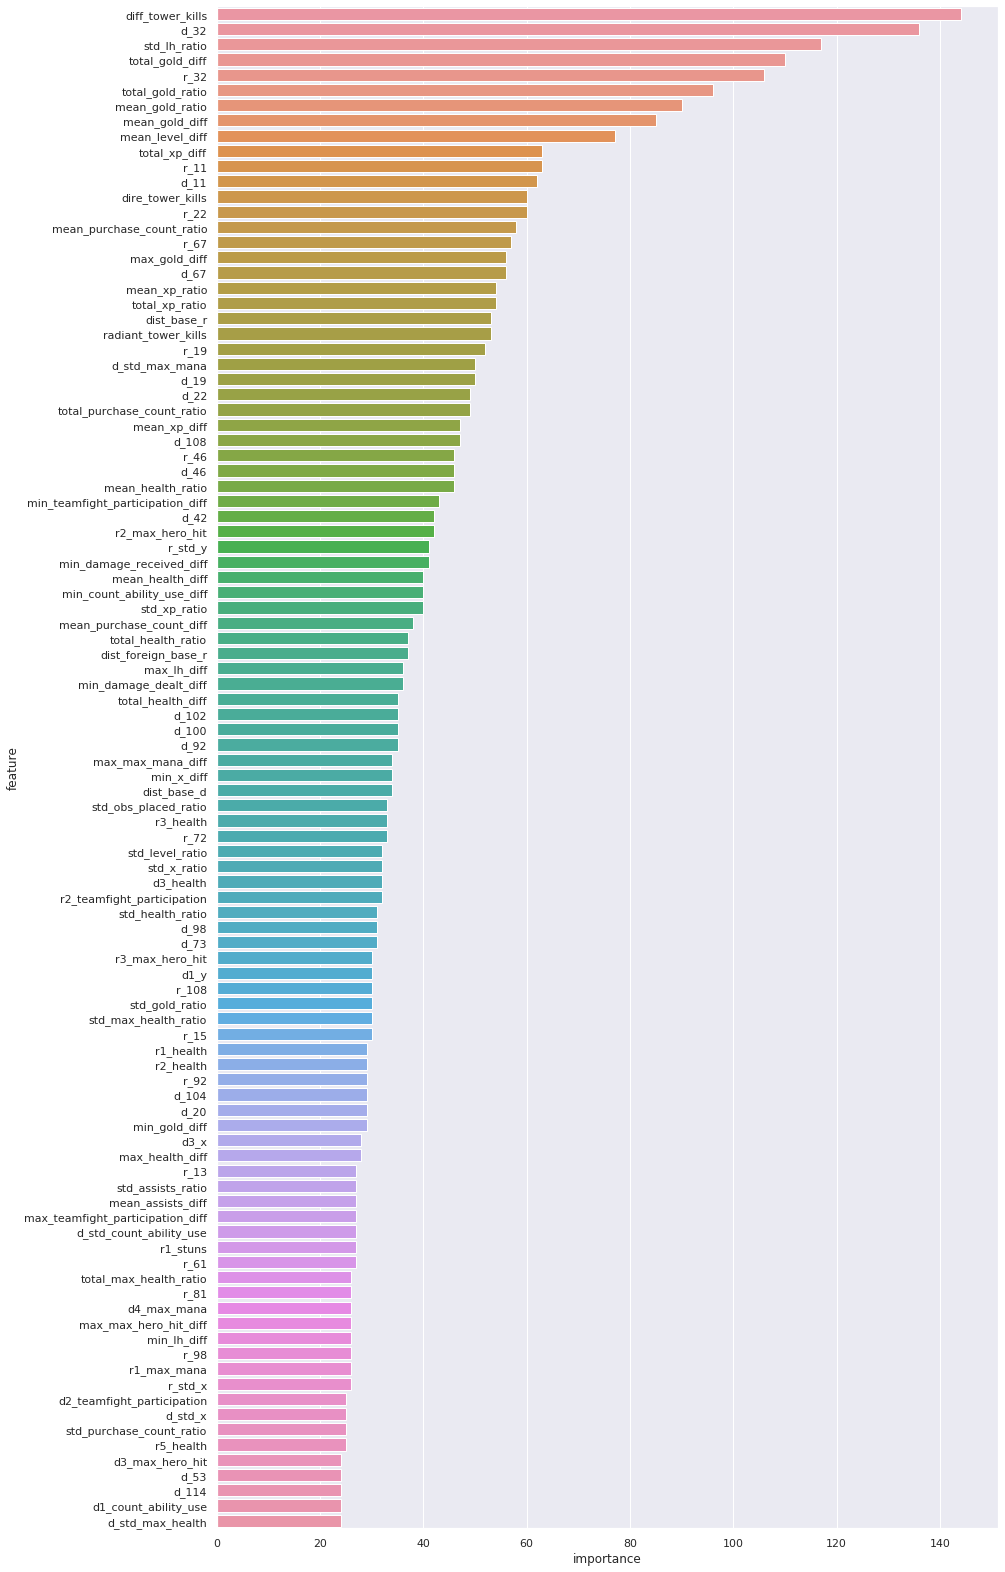

In [0]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance':model.feature_importance()}).sort_values('importance', ascending=False)[:100]

plt.figure(figsize=(14,28))
sns.barplot(x=feature_importance.importance, y=feature_importance.feature);

In [0]:
df_submission_extended = pd.DataFrame(
    {'radiant_win_prob': y_pred}, 
    index=X_test.index)
df_submission_extended.to_csv('/content/sample_data/submission.csv')

### Третья попытка
использовались функции:
- add_tower_kills,
- add_total_mean,
- add_hero_dammies,
- del_hero_id,
- add_dist_base,
- add_dist_foreign_base
- add_pred_from_hero

Использовались параметры (со второй попытки):

{'lambda_l1': 0.652988641442232,
 'lambda_l2': 4.906733861405735,
 'max_depth': 62.83130590004101,
 'min_child_samples': 1901.9948496115514,
 'min_data_in_leaf': 299.60048120319516,
 'num_leaves': 15.230882740020132}

добавляем признаки

In [0]:
func_list = [add_tower_kills,
             add_total_mean,
             add_hero_dammies,
             del_hero_id,
             add_dist_base,
             add_dist_foreign_base,
             add_pred_from_hero,
             ]

In [0]:
%%time


matches_file = os.path.join(path_data, 'train_matches.jsonl')
X_train = transform(df_new_features, func_list, matches_file)
y_train = df_new_targets['radiant_win']


func add_tower_kills added
func add_total_mean added
func add_hero_dammies added
func del_hero_id added
func add_dist_base added
func add_dist_foreign_base added
func add_pred_from_hero added
CPU times: user 13min 36s, sys: 11.9 s, total: 13min 48s
Wall time: 13min 47s


In [0]:
%%time

matches_file = os.path.join(path_data, 'test_matches.jsonl')
df_new_test_features = get_new_features(matches_file)
X_test = transform(df_new_test_features, func_list, matches_file)


func add_tower_kills added
func add_total_mean added
func add_hero_dammies added
func del_hero_id added
func add_dist_base added
func add_dist_foreign_base added
func add_pred_from_hero added
CPU times: user 7min 27s, sys: 6.06 s, total: 7min 33s
Wall time: 7min 35s


In [0]:
params = {'lambda_l1': 0.652988641442232,
            'lambda_l2': 4.906733861405735,
            'max_depth': 62.83130590004101,
            'min_child_samples': 1901.9948496115514,
            'min_data_in_leaf': 299.60048120319516,
            'num_leaves': 15.230882740020132}

categorical_features = ['lobby_type', 'game_mode']

In [0]:
pred_test_y1, _ = lgb_train(**params)
pred_test_y2, _ = lgb_train(**params)
pred_test_y3, model = lgb_train(**params)
y_pred = (pred_test_y1 + pred_test_y2 + pred_test_y3)/3

/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.85092
[400]	valid_0's auc: 0.850014
[600]	valid_0's auc: 0.849373
Early stopping, best iteration is:
[218]	valid_0's auc: 0.851003
Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.849122
[400]	valid_0's auc: 0.848566
[600]	valid_0's auc: 0.847251
Early stopping, best iteration is:
[297]	valid_0's auc: 0.849481
Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.84392
[400]	valid_0's auc: 0.843962
[600]	valid_0's auc: 0.84307
Early stopping, best iteration is:
[253]	valid_0's auc: 0.84428


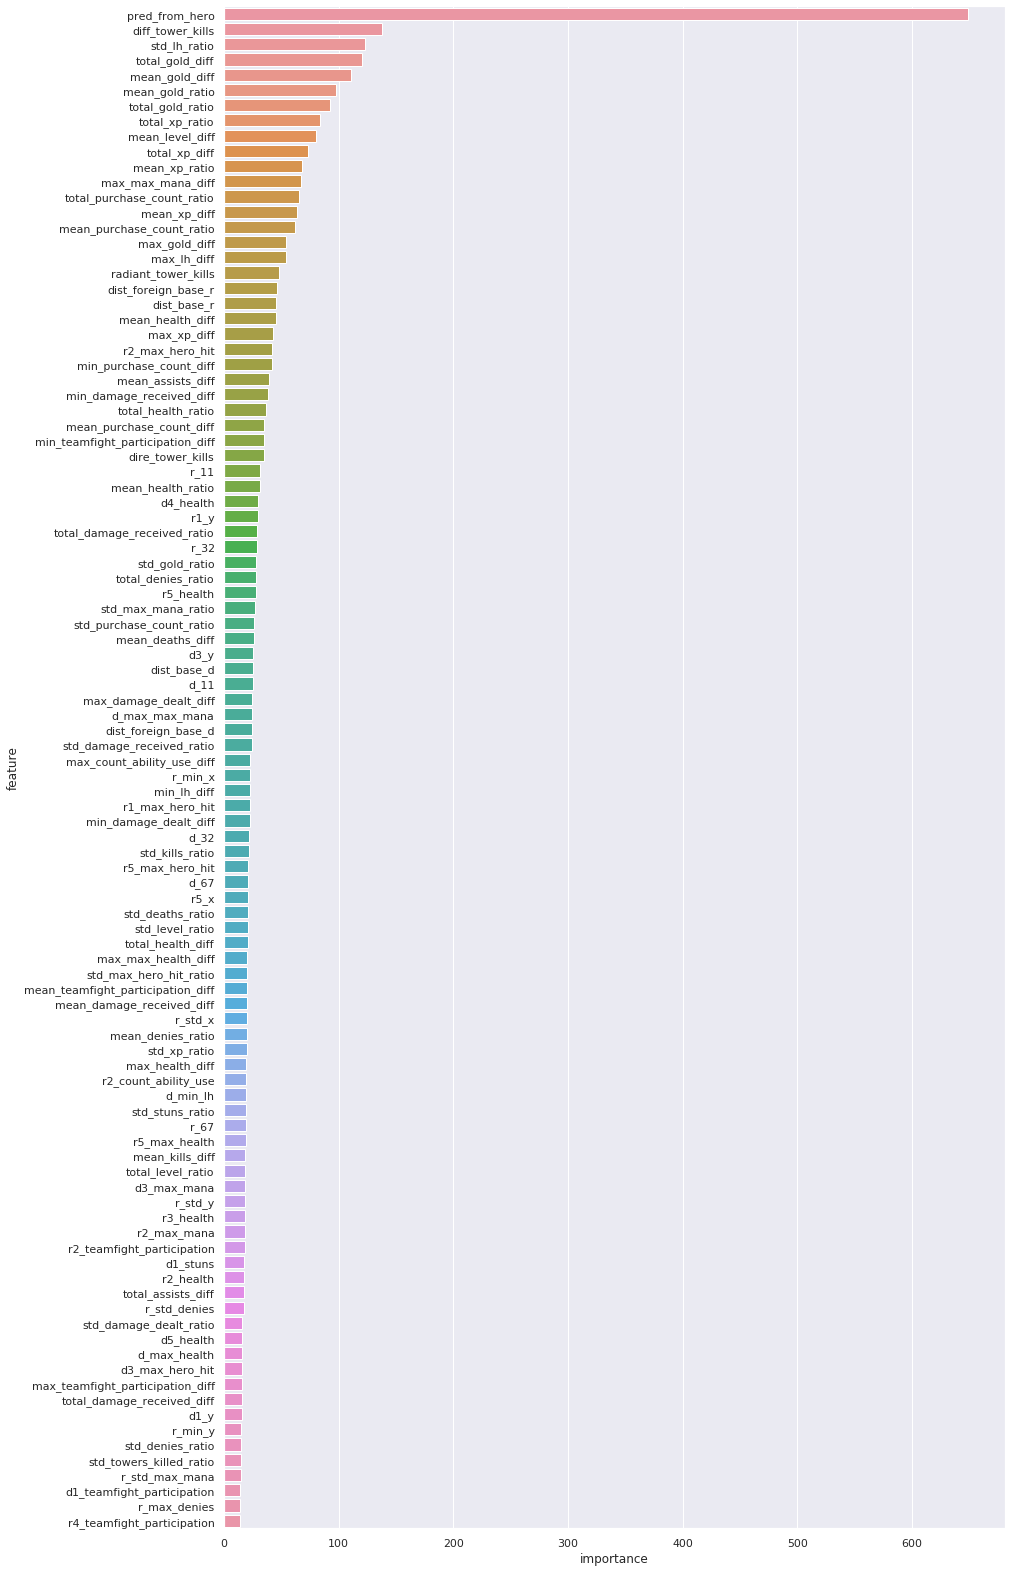

In [0]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance':model.feature_importance()}).sort_values('importance', ascending=False)[:100]

plt.figure(figsize=(14,28))
sns.barplot(x=feature_importance.importance, y=feature_importance.feature);

In [0]:
df_submission_extended = pd.DataFrame(
    {'radiant_win_prob': y_pred}, 
    index=X_test.index)
df_submission_extended.to_csv('/content/sample_data/submission_15.11.2019_15.00.csv')

In [0]:
df_submission_extended = pd.DataFrame(
    {'radiant_win_prob': y_pred}, 
    index=X_test.index)
df_submission_extended.to_csv(path_data + 'submission_15.11.2019_15.00.csv')

### Четвертая попытка
принудительное разбиение дерева в корне по 23 типу игры
использовались функции:
- add_tower_kills,
- add_total_mean,
- add_hero_dammies,
- del_hero_id,
- add_dist_base,
- add_dist_foreign_base

Использовались параметры (со второй попытки):

{'lambda_l1': 0.652988641442232,
 'lambda_l2': 4.906733861405735,
 'max_depth': 62.83130590004101,
 'min_child_samples': 1901.9948496115514,
 'min_data_in_leaf': 299.60048120319516,
 'num_leaves': 15.230882740020132}

In [0]:
func_list = [add_tower_kills,
             add_total_mean,
             add_hero_dammies,
             del_hero_id,
             add_dist_base,
             add_dist_foreign_base,
             ]

In [0]:
%%time


matches_file = os.path.join(path_data, 'train_matches.jsonl')
X_train = transform(df_new_features, func_list, matches_file)
y_train = df_new_targets['radiant_win']


func add_tower_kills added
func add_total_mean added
func add_hero_dammies added
func del_hero_id added
func add_dist_base added
func add_dist_foreign_base added
func add_pred_from_hero added
CPU times: user 13min 24s, sys: 10.3 s, total: 13min 34s
Wall time: 13min 35s


In [0]:
%%time

matches_file = os.path.join(path_data, 'test_matches.jsonl')
df_new_test_features = get_new_features(matches_file)
X_test = transform(df_new_test_features, func_list, matches_file)


func add_tower_kills added
func add_total_mean added
func add_hero_dammies added
func del_hero_id added
func add_dist_base added
func add_dist_foreign_base added
func add_pred_from_hero added
CPU times: user 7min 27s, sys: 4.41 s, total: 7min 31s
Wall time: 7min 36s


In [0]:
y_train.head()

match_id_hash
a400b8f29dece5f4d266f49f1ae2e98a    False
b9c57c450ce74a2af79c9ce96fac144d     True
6db558535151ea18ca70a6892197db41     True
46a0ddce8f7ed2a8d9bd5edcbb925682     True
b1b35ff97723d9b7ade1c9c3cf48f770    False
Name: radiant_win, dtype: bool

In [0]:
%%time 

X = X_train.values
y = y_train

cv_scores1 = simple_tree(X, y, cv=cv)
print(cv_scores1)
print(np.mean(cv_scores1))

[0.81904704 0.82104971 0.82174412 0.82037208 0.81799081]
0.8200407528651315
CPU times: user 8.84 s, sys: 1.66 s, total: 10.5 s
Wall time: 3min 6s


In [0]:
X_train['game_mode_turbo'] = (X_train['game_mode'] == 23).astype(int)
X_test['game_mode_turbo'] = (X_test['game_mode'] == 23).astype(int)

In [0]:
%%time 

X = X_train.values
y = y_train

cv_scores1 = simple_tree(X, y, cv=cv)
print(cv_scores1)
print(np.mean(cv_scores1))

[0.81759018 0.82199747 0.82235335 0.81843469 0.81827294]
0.8197297249702222
CPU times: user 8.68 s, sys: 1.67 s, total: 10.3 s
Wall time: 3min 4s


In [0]:
# create json file that forces the tree to split by the new feature. threshold is 0.5.
s = """
{
    "feature": "game_mode_turbo",
    "threshold": 0.5,
    "left": {
    },
    "right": {
    }
}
"""

with open("forced_splits-game_mode_turbo.json", mode='w') as f:
    f.write(s)

In [0]:
params = {'lambda_l1': 0.652988641442232,
            'lambda_l2': 4.906733861405735,
            'max_depth': 62.83130590004101,
            'min_child_samples': 1901.9948496115514,
            'min_data_in_leaf': 299.60048120319516,
            'num_leaves': 15.230882740020132}

categorical_features = ['lobby_type', 'game_mode']

In [0]:
pred_test_y1, _ = lgb_train(**params)
pred_test_y2, _ = lgb_train(**params)
pred_test_y3, model = lgb_train(**params)
y_pred = (pred_test_y1 + pred_test_y2 + pred_test_y3)/3

/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.835698
[400]	valid_0's auc: 0.839185
[600]	valid_0's auc: 0.839587
[800]	valid_0's auc: 0.839285
[1000]	valid_0's auc: 0.838767
Early stopping, best iteration is:
[653]	valid_0's auc: 0.839701
Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.83476
[400]	valid_0's auc: 0.838517
[600]	valid_0's auc: 0.838985
[800]	valid_0's auc: 0.838812
[1000]	valid_0's auc: 0.838297
Early stopping, best iteration is:
[676]	valid_0's auc: 0.839118
Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.843576
[400]	valid_0's auc: 0.847167
[600]	valid_0's auc: 0.847652
[800]	valid_0's auc: 0.847589
[1000]	valid_0's auc: 0.847551
Early stopping, best iteration is:
[646]	valid_0's auc: 0.847844


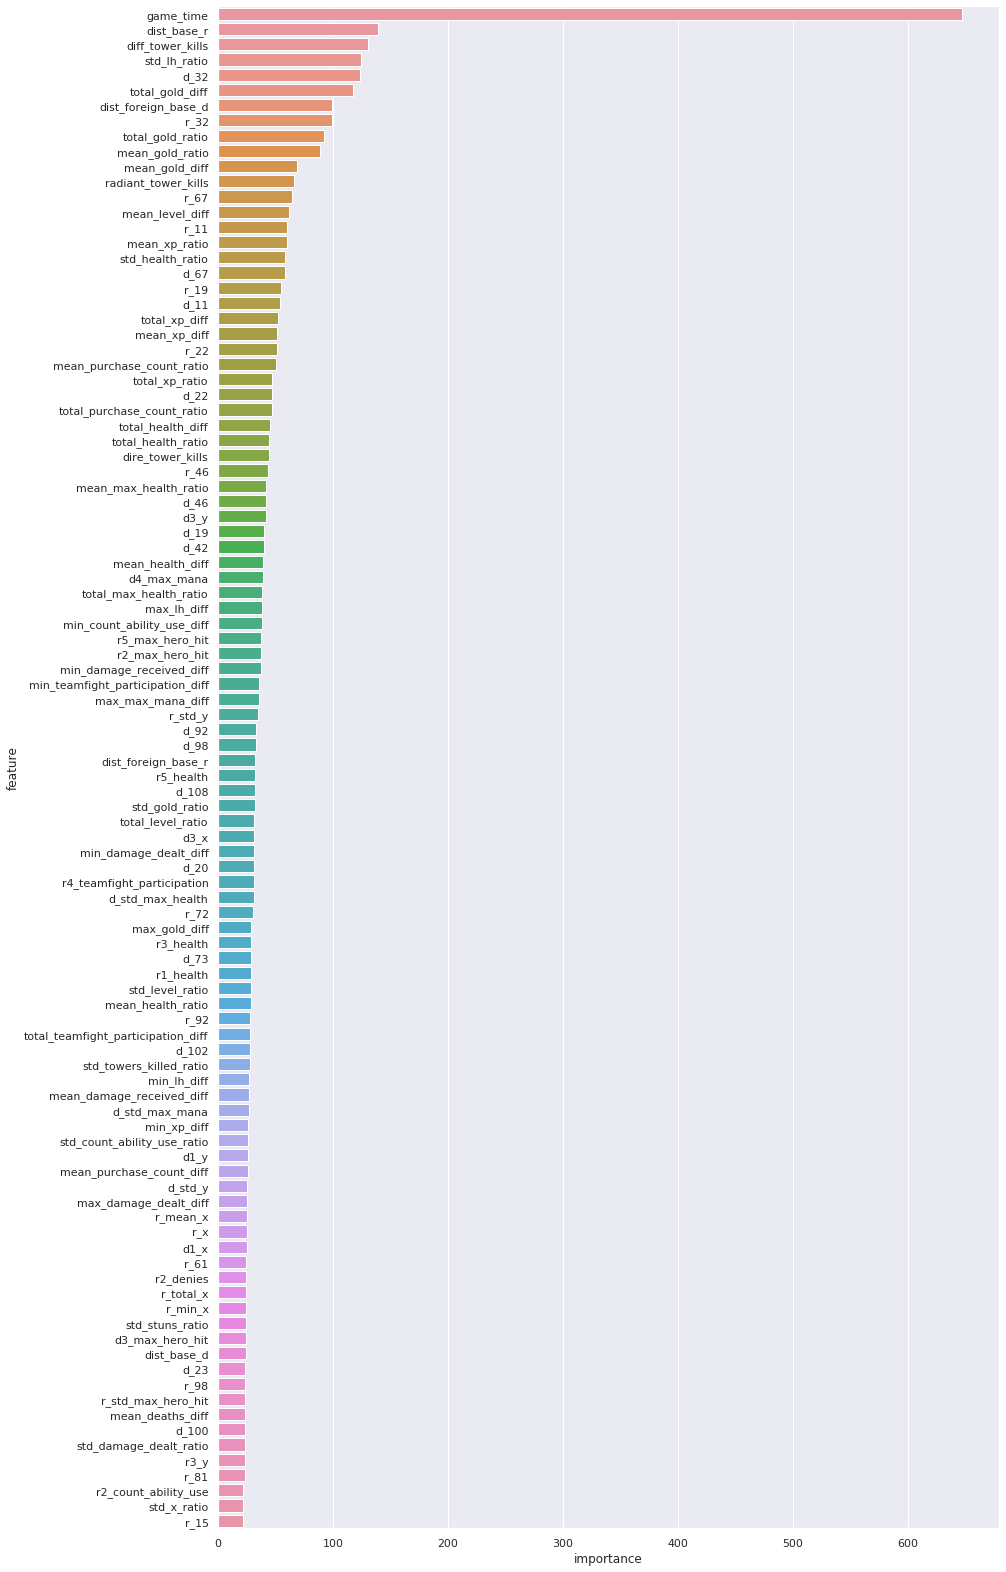

In [0]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance':model.feature_importance()}).sort_values('importance', ascending=False)[:100]

plt.figure(figsize=(14,28))
sns.barplot(x=feature_importance.importance, y=feature_importance.feature);

In [0]:
df_submission_extended = pd.DataFrame(
    {'radiant_win_prob': y_pred}, 
    index=X_test.index)
df_submission_extended.to_csv('/content/sample_data/submission_16.11.2019_17.00.csv')

### Пятая попытка
использовались модифицированные функции:
- add_tower_kills,
- add_total_mean,
- add_hero_dammies,
- del_hero_id,
- add_dist_base,
- add_dist_foreign_base

Использовались параметры (со второй попытки):

{'lambda_l1': 0.652988641442232,
 'lambda_l2': 4.906733861405735,
 'max_depth': 62.83130590004101,
 'min_child_samples': 1901.9948496115514,
 'min_data_in_leaf': 299.60048120319516,
 'num_leaves': 15.230882740020132}

In [0]:
func_list = [add_total_mean,
             add_tower_kills,
             add_hero_dammies,
             del_hero_id,
             add_dist_base,
             add_dist_foreign_base,
             ]

In [0]:
%%time


matches_file = os.path.join(path_data, 'train_matches.jsonl')
X_train = transform(df_new_features, func_list, matches_file)
y_train = df_new_targets['radiant_win']

func add_total_mean added



func add_tower_kills added
func add_hero_dammies added
func del_hero_id added
func add_dist_base added
func add_dist_foreign_base added
CPU times: user 10min 6s, sys: 13.5 s, total: 10min 20s
Wall time: 10min 18s


In [0]:
%%time

matches_file = os.path.join(path_data, 'test_matches.jsonl')
df_new_test_features = get_new_features(matches_file)
X_test = transform(df_new_test_features, func_list, matches_file)


func add_total_mean added



func add_tower_kills added
func add_hero_dammies added
func del_hero_id added
func add_dist_base added
func add_dist_foreign_base added
CPU times: user 4min 2s, sys: 3.55 s, total: 4min 6s
Wall time: 4min 11s


In [0]:
%%time 

X = X_train.values
y = y_train

cv_scores1 = simple_tree(X, y, cv=cv)
print(cv_scores1)
print(np.mean(cv_scores1))

[0.81977904 0.82070455 0.82397634 0.82050128 0.81868511]
0.8207292641605092
CPU times: user 12.9 s, sys: 2.53 s, total: 15.4 s
Wall time: 3min 27s


In [0]:
params = {'lambda_l1': 0.652988641442232,
            'lambda_l2': 4.906733861405735,
            'max_depth': 62.83130590004101,
            'min_child_samples': 1901.9948496115514,
            'min_data_in_leaf': 299.60048120319516,
            'num_leaves': 15.230882740020132}

categorical_features = ['lobby_type', 'game_mode']

In [0]:
pred_test_y1, _ = lgb_train(**params)
pred_test_y2, _ = lgb_train(**params)
pred_test_y3, model = lgb_train(**params)
y_pred = (pred_test_y1 + pred_test_y2 + pred_test_y3)/3

/content/LightGBM/python-package/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.833781
[400]	valid_0's auc: 0.838198
[600]	valid_0's auc: 0.83938
[800]	valid_0's auc: 0.839602
[1000]	valid_0's auc: 0.839499
Early stopping, best iteration is:
[743]	valid_0's auc: 0.839651
Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.83502
[400]	valid_0's auc: 0.837775
[600]	valid_0's auc: 0.838277
[800]	valid_0's auc: 0.838138
[1000]	valid_0's auc: 0.837644
Early stopping, best iteration is:
[638]	valid_0's auc: 0.838414
Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.834464
[400]	valid_0's auc: 0.839253
[600]	valid_0's auc: 0.840467
[800]	valid_0's auc: 0.840732
[1000]	valid_0's auc: 0.840603
Early stopping, best iteration is:
[769]	valid_0's auc: 0.840831


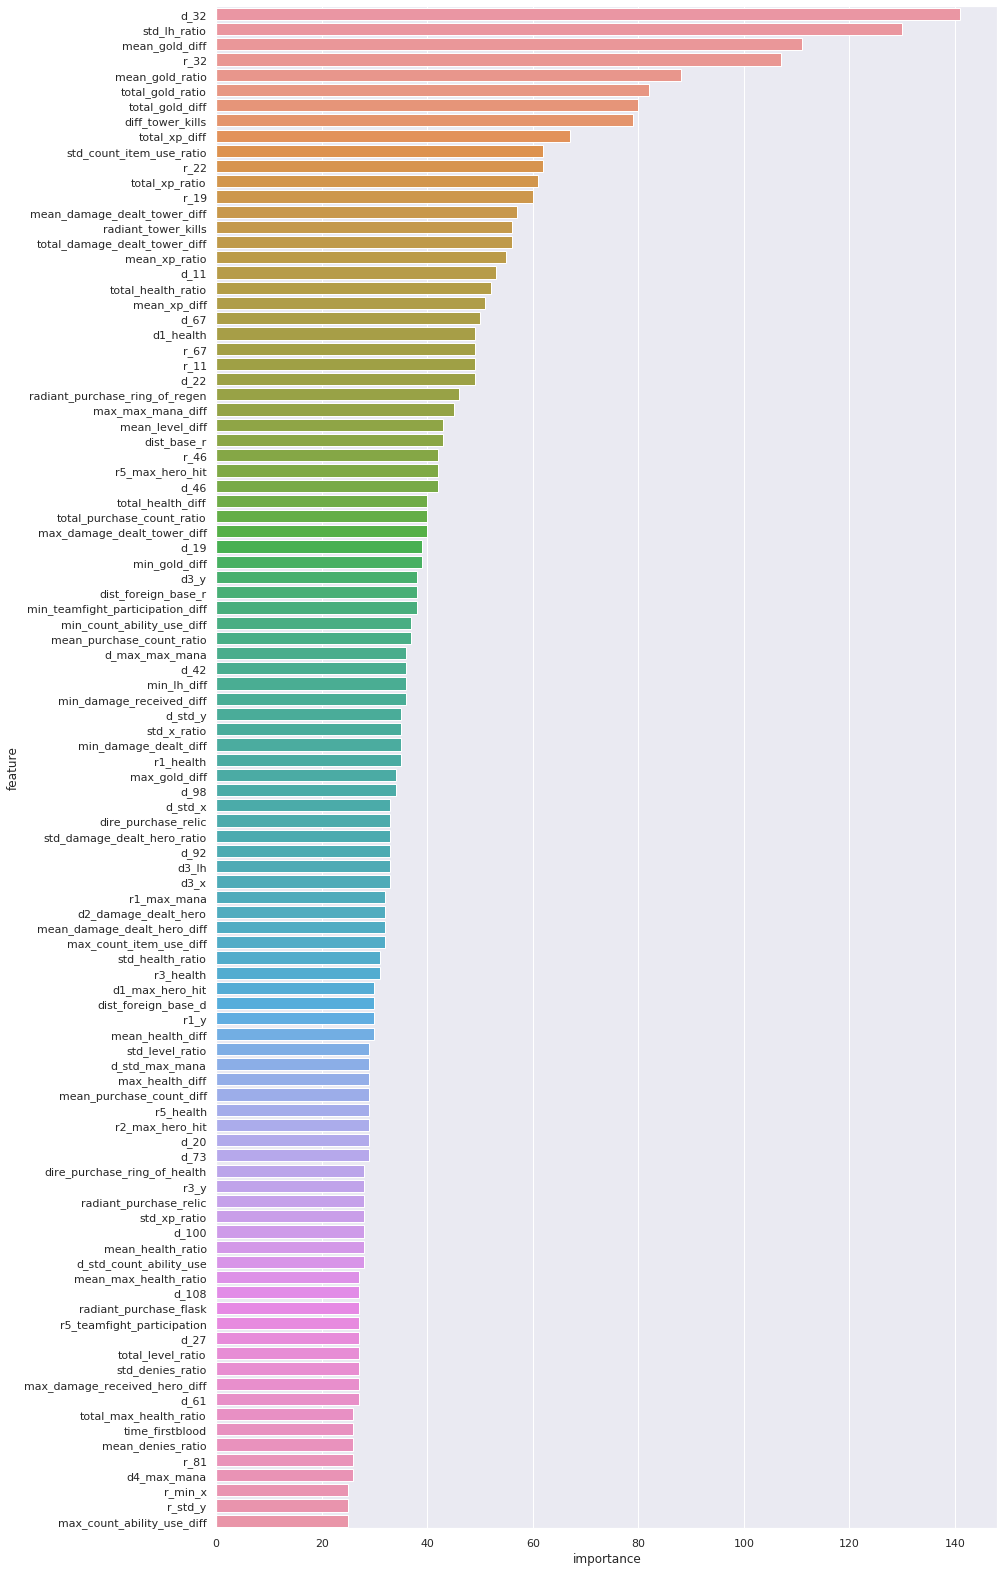

In [0]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance':model.feature_importance()}).sort_values('importance', ascending=False)[:100]

plt.figure(figsize=(14,28))
sns.barplot(x=feature_importance.importance, y=feature_importance.feature);

In [0]:
df_submission_extended = pd.DataFrame(
    {'radiant_win_prob': y_pred}, 
    index=X_test.index)
df_submission_extended.to_csv('/content/sample_data/submission_17.11.2019_13.00.csv')

In [0]:
df_submission_extended = pd.DataFrame(
    {'radiant_win_prob': y_pred}, 
    index=X_test.index)
df_submission_extended.to_csv('/content/drive/My Drive/Courses/mlcourse/4/data_dota2/submission_17.11.2019_04.00.csv')

### Попруем убрать лишние признаки

In [0]:
!pip install catboost

     |████████████████████████████████| 62.9MB 148kB/s 


In [0]:
model = RandomForestClassifier(n_estimators=100, 
                                   max_depth=None, 
                                   #min_samples_leaf=3, 
                                   n_jobs=-1, 
                                   random_state=17)

In [0]:
%%time

X = X_train.values
y = y_train
base_score, feature_importance = calc_importance(X, y, X_train.columns, model)

CPU times: user 13h 57min 15s, sys: 7min 40s, total: 14h 4min 55s
Wall time: 7h 58min 39s


In [0]:
feature_importance.to_excel(path_data + 'feature_importance.xlsx')  

In [0]:
print(base_score)
print(feature_importance)

[0.7778812448343385, 0.7773837607267003, 1.0]
                        Feature  Importance1  Importance2 Importance_all
137                        d1_x   0.00190845  0.000973023    2.44301e-07
42                         r2_y  0.000797721     0.001319    1.64565e-07
18                         r1_y   0.00172702  0.000954624    1.61254e-07
234                        d5_y  4.32515e-05  0.000633771    1.28646e-07
209                        d4_x   0.00159739  0.000576832    8.61038e-08
..                          ...          ...          ...            ...
119       r5_firstblood_claimed  1.93215e-05  9.22021e-05              0
120  r5_teamfight_participation  0.000374747   0.00013635              0
124               r5_sen_placed -0.000136383   0.00010369              0
127                   d1_deaths   0.00152989  0.000868753              0
244               d5_sen_placed -6.40994e-05  6.31977e-05              0

[245 rows x 4 columns]
